# Same Gausssian kernel mapping
<b> This notebook is applicable for Shanghai Tech dataset only. Here same kernel is used for entire dataset. I studied about Gaussian kernel mapping and decided to create own function for it. I used OpenCv. 
<br/><a href = 'https://github.com/CommissarMa/Crowd_counting_from_scratch/blob/master/generate_density_map/same_gaussian_kernel.py'> Click here for the original code i learned from.</a>

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import os
import glob
from scipy import io

print(plt.style.available)
plt.style.use('seaborn-whitegrid')

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


['part_A/train_data/images', 'part_A/test_data/images']


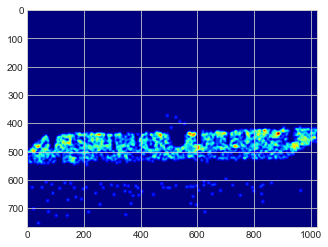

Original: 1546 Generated: 1544


NameError: name 'dmap' is not defined

In [4]:
def show_img(img, cmap = None):
    '''
    img : image to be shown
    '''
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if cmap != None:
        plt.imshow(img, cmap=cm.jet )
    else:
        plt.imshow(img)
    plt.show()

def gkernel(size = 15, sigma = 4.0):
    """
    size : kernel size(usually odd number)
    sigma : standard deviation
    return : gaussian kernel of size(size) and std sigma
    """
    xk = cv2.getGaussianKernel(size, sigma)
    yk = cv2.getGaussianKernel(size, sigma).T
    
    kernel = xk * yk

    return kernel

def density_map(img, points):
    """
    img : image of crowd
    points : annotated points of people
    return : density map of an image
    """
    
    [rows,cols]=[img.shape[0],img.shape[1]]
    d_map=np.zeros([rows,cols])
    k = gkernel()
    normed_k=(1.0 / k.sum()) * k # normalization for each head.

    if len(points) == 0:
        return d_map
    else:
        for p in points:
            r, c = int(p[0]), int(p[1])
            if r >= rows or c >= cols:
                continue
            for x in range(0, k.shape[0]):
                for y in range(0, k.shape[1]):
                    if x+((r+1)-int((k.shape[0]-1)/2))<0 or x+((r+1)-int((k.shape[0]-1)/2))>rows-1 or y+((c+1)-int((k.shape[1]-1)/2))<0 or y+((c+1)-int((k.shape[1]-1)/2))>cols-1:
                        continue
                    else:
                        d_map[x+((r+1)-int((k.shape[0]-1)/2)),y+((c+1)-int((k.shape[1]-1)/2))]+=normed_k[x,y]
    
    
    
    return d_map

# test code
if __name__=="__main__":
    # show an example to use function generate_density_map_with_fixed_kernel.
    root = '/'
    
    # now generate the ShanghaiA's ground truth
    part_A_train = 'part_A/train_data/images'
    part_A_test = 'part_A/test_data/images'
    
#     img_path="part_A/test_data/images/IMG_8.jpg"
    path_sets = [part_A_train,part_A_test]
    
    print(path_sets)
    img_paths = []
    for path in path_sets:
        for img_path in glob.glob(os.path.join(path, '*.jpg')):
            img_paths.append(img_path)
#             print(img_path)
#     print(img_paths)
    for img_path in img_paths:
        img=plt.imread(img_path)
        plt.imshow(img)
        mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
        pts = mat["image_info"][0,0][0,0][0] #1546person*2(col,row)
        points=[]
        for p in pts:
            points.append([p[1],p[0]]) #convert (col,row) to (row,col)


        d_map = density_map(img, points)
        show_img(d_map, 'use')
        print(f'Original: {len(points)} Generated: {int(d_map.sum())}')

        np.save(img_path.replace('.jpg','.npy').replace('images','ground-truth'), d_map)

    
    
    

In [5]:
# Prepare dataloader

from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2


class CrowdDataset(Dataset):
    '''
    crowdDataset
    '''
    def __init__(self,img_root,gt_dmap_root,gt_downsample=1):
        '''
        img_root: the root path of img.
        gt_dmap_root: the root path of ground-truth density-map.
        gt_downsample: default is 0, denote that the output of deep-model is the same size as input image.
        '''
        self.img_root=img_root
        self.gt_dmap_root=gt_dmap_root
        self.gt_downsample=gt_downsample

        self.img_names=[filename for filename in os.listdir(img_root) \
                           if os.path.isfile(os.path.join(img_root,filename))]
        self.n_samples=len(self.img_names)

    def __len__(self):
        return self.n_samples

    def __getitem__(self,index):
        assert index <= len(self), 'index range error'
        img_name=self.img_names[index]
        img=plt.imread(os.path.join(self.img_root,img_name))
        if len(img.shape)==2: # expand grayscale image to three channel.
            img=img[:,:,np.newaxis]
            img=np.concatenate((img,img,img),2)

        gt_dmap=np.load(os.path.join(self.gt_dmap_root,img_name.replace('.jpg','.npy')))
        # print(gt_dmap.sum())
        if self.gt_downsample>1: # to downsample image and density-map to match deep-model.
            ds_rows=int(img.shape[0]//self.gt_downsample)
            ds_cols=int(img.shape[1]//self.gt_downsample)
            img = cv2.resize(img,(ds_cols*self.gt_downsample,ds_rows*self.gt_downsample))
            img=img.transpose((2,0,1)) # convert to order (channel,rows,cols)
            gt_dmap=cv2.resize(gt_dmap,(ds_cols,ds_rows))
            gt_dmap=gt_dmap[np.newaxis,:,:]*self.gt_downsample*self.gt_downsample
        
        img_tensor=torch.tensor(img,dtype=torch.float)
        gt_dmap_tensor=torch.tensor(gt_dmap,dtype=torch.float)
        # print(gt_dmap_tensor.sum())

        return img_tensor,gt_dmap_tensor


# test code
if __name__=="__main__":
    img_root="part_A/train_data/images"
    gt_dmap_root="part_A/train_data/ground-truth"
    dataset=CrowdDataset(img_root,gt_dmap_root,gt_downsample=4)
    for i,(img,gt_dmap) in enumerate(dataset):
        # plt.imshow(img)
        # plt.figure()
        # plt.imshow(gt_dmap)
        # plt.figure()
        print(img.shape,gt_dmap.shape)

torch.Size([3, 768, 1024]) torch.Size([1, 192, 256])
torch.Size([3, 680, 1024]) torch.Size([1, 170, 256])
torch.Size([3, 652, 1024]) torch.Size([1, 163, 256])
torch.Size([3, 768, 1024]) torch.Size([1, 192, 256])
torch.Size([3, 768, 1024]) torch.Size([1, 192, 256])
torch.Size([3, 400, 400]) torch.Size([1, 100, 100])
torch.Size([3, 404, 540]) torch.Size([1, 101, 135])
torch.Size([3, 632, 988]) torch.Size([1, 158, 247])
torch.Size([3, 672, 1024]) torch.Size([1, 168, 256])
torch.Size([3, 516, 800]) torch.Size([1, 129, 200])
torch.Size([3, 764, 1024]) torch.Size([1, 191, 256])
torch.Size([3, 680, 1024]) torch.Size([1, 170, 256])
torch.Size([3, 684, 1024]) torch.Size([1, 171, 256])
torch.Size([3, 496, 1024]) torch.Size([1, 124, 256])
torch.Size([3, 768, 1024]) torch.Size([1, 192, 256])
torch.Size([3, 324, 1024]) torch.Size([1, 81, 256])
torch.Size([3, 388, 600]) torch.Size([1, 97, 150])
torch.Size([3, 372, 500]) torch.Size([1, 93, 125])
torch.Size([3, 608, 1020]) torch.Size([1, 152, 255])
to

In [9]:
import torch
import torch.nn as nn


class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))
    
    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x


# test code
if __name__=="__main__":
    img=torch.rand((1,3,800,1200),dtype=torch.float)
    mcnn=MCNN()
    out_dmap=mcnn(img)
    #show_img(out_dmap)
    print(out_dmap.shape)

KeyboardInterrupt: 